## load data

In [2]:
import pandas as pd
# load transactions
df=pd.read_csv('data/transactions_train.csv')

In [3]:
# load articles
dfa=pd.read_csv('data/articles.csv')

In [4]:
dfa.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [5]:
df.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

## preprocessing

In [6]:
# select relevant features :transactions
df=df[['t_dat','customer_id','article_id']]
df.head(3)

,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004


In [7]:
# drop dyplicates in customer's basket (e.g. the customer's bought two similar items in one purchase)
df=df.drop_duplicates(['t_dat','customer_id','article_id'])

In [9]:
# create baskets (Articles that are bought by a customer in one shop make a basket)
df_basket=df.groupby(['t_dat','customer_id'])['article_id'].apply(lambda x: ','.join(map(str,x))).reset_index(name='itemset')

## save data 

In [10]:
# save data for further process
df_basket['itemset'].to_csv('data/itemsets.csv')

## data analyzation

<div class="alert alert-block alert-info">
<b>data description:</b> The total number of unique articles is 104,547. <br>  
The total number of articles have been bought from 2018 to 2020 is 28,575,395.
</div>

In [11]:
# total number of unique articles
len(pd.unique(df.article_id))

104547

In [12]:
# frequency of articles that are bought (most common and least common)
from collections import Counter
# dictionary of each article_id and its frequency
count=Counter(list(df['article_id']))

In [13]:
# convert Counter object to a dataframe
df_count = pd.DataFrame.from_dict(count, orient='index').reset_index()
df_count = df_count.rename(columns={'index':'article_id', 0:'frequency'})
df_count.head(3)

,article_id,frequency
0,663713001,584
1,541518023,427
2,505221004,42


In [14]:
# total number of articles have been bought
sum(df_count.frequency)

28575395

In [15]:
# group the articles based on their frequency (explanation: 4668 articles are sold just once)
df_articleFreq= df_count.groupby(['frequency'])['frequency'].count().reset_index(name='num_articles')
df_articleFreq.head(3)

,frequency,num_articles
0,1,4668
1,2,3381
2,3,2806


**From all articles that we have, we are interested in articles that appeared more frequently in the shopping baskets.**

In [23]:
# how many articles appeared more frequently in shopping baskets
sum(df_articleFreq[df_articleFreq.frequency > 2000]['num_articles'])

2158

### shopping patterns for most common articles

In [24]:
# most common articles (first 3 ones)
count.most_common(3)

[(706016001, 42146), (706016002, 30544), (372860001, 29179)]

In [25]:
df_common = df[(df['article_id']==706016001) | (df['article_id']==372860001)][['t_dat','article_id']]
df_common['t_dat']= pd.to_datetime(df_common['t_dat'], format='%Y-%m-%d')
df_common_count=df_common.groupby(['article_id','t_dat'])['article_id'].count().reset_index(name='count').set_index('t_dat')

<AxesSubplot:title={'center':'number of items have been sold in a month'}, xlabel='t_dat'>

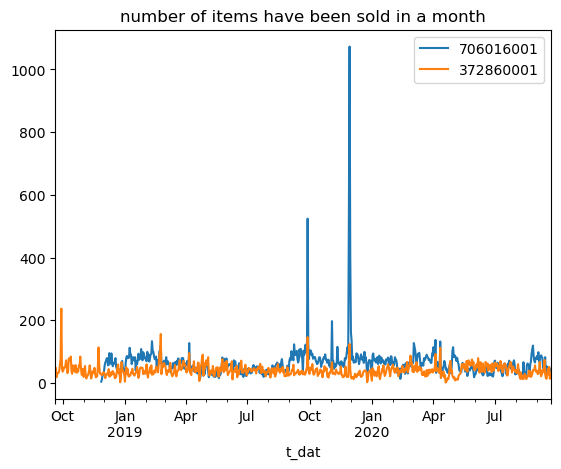

In [26]:
# plot the shopping pattern for the most common item in shopping baskets
df_common_count[df_common_count['article_id']==706016001]['count'].plot(label='706016001',legend=True,title='number of items have been sold in a month')
df_common_count[df_common_count['article_id']==372860001]['count'].plot(label='372860001',legend=True)

**To get the name of articles that are interested, we create a dictionary from the articles ids and names. Then, we can map the values from two dataframes.**

In [27]:
# get relevant features: articles
dfa = dfa[['article_id', 'prod_name']]
# generate dictionary key: article_id, value: product_name
dfa_dict=dict(zip(dfa.article_id,dfa.prod_name))

In [28]:
# return name of most common products (mapping)
[dfa_dict[x] for x in [706016001,706016002,372860001]]

['Jade HW Skinny Denim TRS', 'Jade HW Skinny Denim TRS', '7p Basic Shaftless']

### Distribution of number of baskets

*Plot number of purchases for different basket size*

In [30]:
# calculate size of baskets for each purchase 
df_basket1 = df_basket[['itemset']].copy()
df_basket1['size_basket']=df_basket1['itemset'].apply(lambda x: len(x.split(',')))

# Compute the frequeny of different size of baskets(how many times baskets of size 3 have been purchased)
df_basket2= df_basket1.groupby(['size_basket'])['size_basket'].count().reset_index(name='count')
df_basket2.head(3)

,size_basket,count
0,1,2969840
1,2,2149197
2,3,1323955


**Less than 100 purchases (out of 9,080,179) have the basket size bigger that 50 articles. We remove these purchases with big basket size because they are likely belong to not ordinary customers (maybe other shopping centers and companies).**

In [31]:
print('total purchase: {}, purchase in big basket:{}'.format(len(df_basket1),len(df_basket1[df_basket1['size_basket']>50])))

total purchase: 9080179, purchase in big basket:98


In [32]:
import math
# prepare data for plot
df_basket2=df_basket2[df_basket2['size_basket']<=50]
df_basket2['size_basket']=df_basket2['size_basket'].astype(str)
# scaling down large values
df_basket2['count']=df_basket2['count'].apply(lambda x: math.log(x))

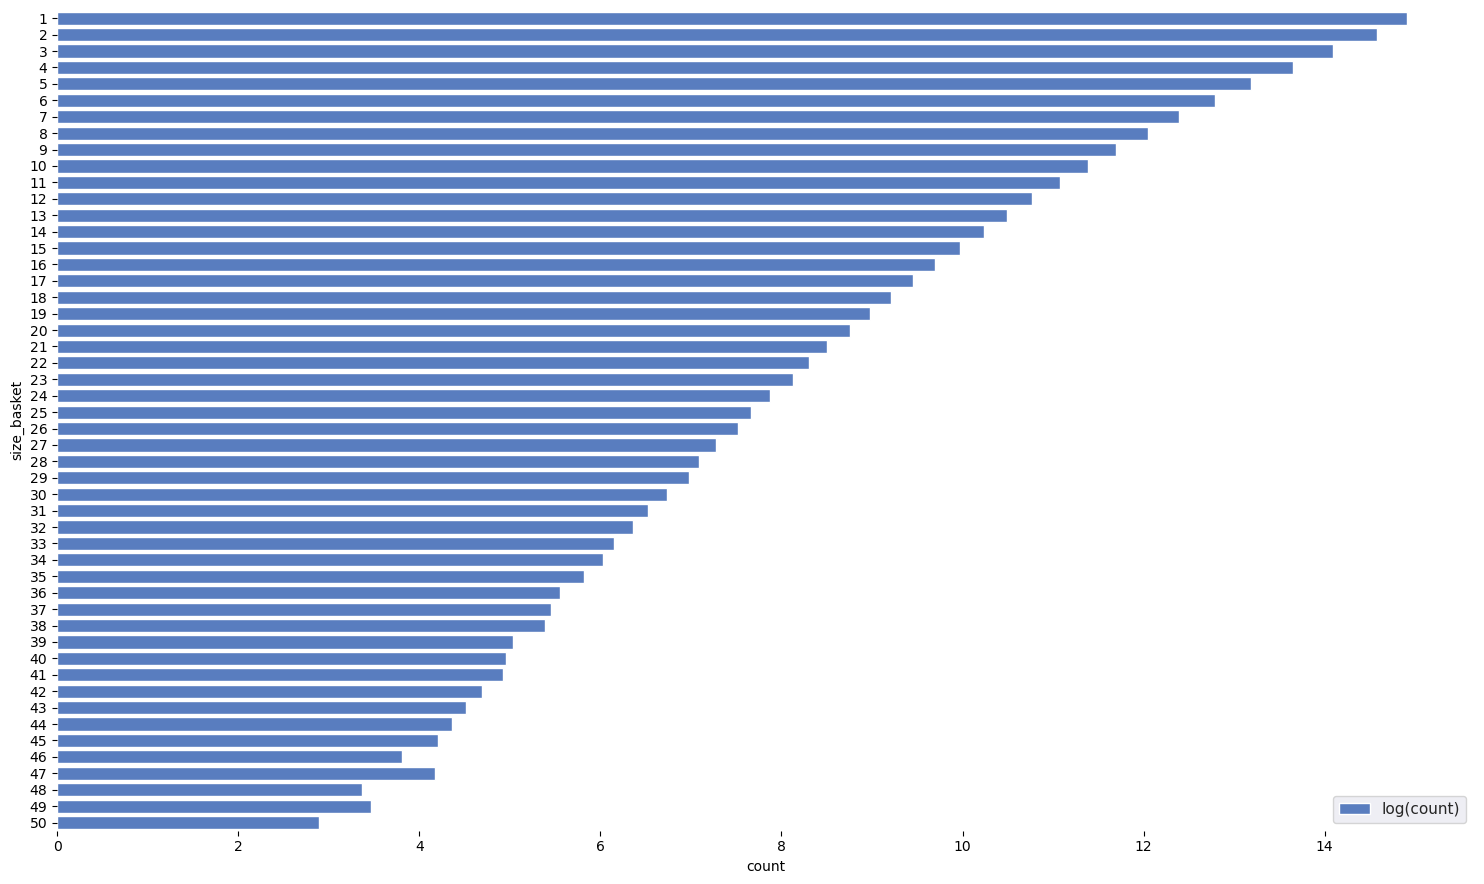

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(15,9))

sns.set(style="darkgrid")

sns.set_color_codes("muted")
sns.barplot(x="count", y="size_basket", data=df_basket2, label="log(count)",color="b")

sns.despine(left=True, bottom=True)
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.tight_layout()
plt.show()